## A short tutorial how to use Ignis within Python Jupyter notebooks

First, import the Ignis API. Depending on the way you installed Ignis, this might differ for you.
In our case we simply adapt the module search path to include our Ignis library.

In [1]:
import sys
from pathlib import Path

def load_api():
    import importlib

    # Load the api and return a module object
    api_dir = Path("/home/haddington/dev/Ignis/build/Release/api") # <----------- Adapt this to your need. 
    # The directory has to contain a directory 'ignis' containing a shared library 'pyignis*'.
    # The actual name of the shared library depends on your Python version and operating system.

    if not api_dir.exists():
        raise RuntimeError(
            "Could not find the api directory! Maybe the Python API is not enabled via cmake?")

    ig_dir = api_dir.joinpath("ignis")
    if not ig_dir.exists():
        raise RuntimeError(
            "Could not find the ignis directory inside the api directory! Maybe the Python API is not enabled via cmake?")

    spec = importlib.util.spec_from_file_location(
        "ignis", ig_dir.joinpath("__init__.py"))
    module = importlib.util.module_from_spec(spec)
    sys.modules[spec.name] = module
    spec.loader.exec_module(module)

    return module

ignis = load_api()

The Ignis API should now be available! Check it with the following simple line:

In [2]:
ignis.__version__

'0.3'

To proceed, lets build a scene directly inside Python. Our scene will contain two spheres, a plane as a floor. The scene will be lit by a simple pointlight directly at the center. The camera is positioned to look at the center from outside downwards.

In [3]:
def create_scene():
    # A scene can be defined directly within Python, as it is just a simple json file
    scene_desc = {
        "technique": {
            "type": "path",
            "max_depth": 32
        },
        "camera": {
            "type": "perspective",
            "fov": 90,
            "near_clip": 0.01,
            "far_clip": 100,
            "transform": [{"lookat": { "origin": [-1,-2,2], "up": [0,0,1], "target": [0,0,0]}}]
        },
        "film": {
            "size": [1024, 1024]
        },
        "bsdfs": [
            {"type": "diffuse", "name": "ground", "reflectance": 0.95},
            {"type": "diffuse", "name": "sphere_left", "reflectance": [0, 0, 1]},
            {"type": "diffuse", "name": "sphere_right", "reflectance": [0, 1, 0]}
        ],
        "shapes": [
            {"type": "sphere", "name": "Sphere", "radius": 1},
            {"type": "rectangle", "name": "Bottom", "width": 10, "height": 10}
        ],
        "entities": [
            {"name": "Bottom", "shape": "Bottom", "bsdf": "ground", "transform": [{"translate": [0,0,-2]}]},
            {"name": "SphereLeft", "shape": "Sphere", "bsdf": "sphere_left", "transform": [{"translate": [1,0,0]}]},
            {"name": "SphereRight", "shape": "Sphere", "bsdf": "sphere_right", "transform": [{"translate": [-1,1,0]}]}
        ],
        "lights": [
            {"name": "PointLight", "type": "point", "position": [0,0,3], "intensity": [100, 100, 100]}
        ]
    }

    # Ignis requires a string, so we convert the dictionary description to a json string
    import json

    # Load the scene
    return ignis.Scene.loadFromString(json.dumps(scene_desc))

Due to using a script we could add parameters to our scene and adapt it every time we use the `create_scene()` function. But lets keep it simple and proceed to finally render the scene!

In [4]:
# We require numpy (or any library support the buffer interface of Python) to work with the final output
import numpy as np

# This function will render a scene until the target samples per pixel is reached and return the correct normalized image back to the callee. 
def render(scene, spp):
    with ignis.loadFromScene(scene) as runtime:
        for _i in range(spp):
            runtime.step()
        color = np.asarray(runtime.getFramebuffer()) / runtime.IterationCount
        return color

Ok, we did not render it, but we created a simple function able to render any scene for a user-given number of samples. The higher the SPP, the better the image looks but the longer it takes to render.

Without further ado, lets render!

In [5]:
scene = create_scene() # Our previously defined scene
output = render(scene, 64) # We render the scene for only 64spp

[Info   ] Using target GPU[Nvidia,D=0]
[Info   ] Using device Quadro T2000 with Max-Q Design


The image is rendered, but we still have to display it here on Jupyter. To do so, use your favorite plotting library and basically show it.

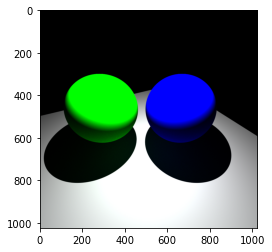

In [9]:
from matplotlib import pyplot as plt
plt.imshow(np.clip(output, 0, 1))
plt.show()

The final image is rendered, our job is done. But, we could make it better by simply applying some tonemapping to it. 

The produced image is a HDR and not bounded between [0, 1] like usual images. Unfortunately, most displays are only able to display images within that small range. To make it possible to display it on all monitors or the internet we will now apply a very basic `reinhard` tonemapping.

In [7]:
# The following function computes the luminance of sRGB colors
def luminance(image):
    r = image[:, :, 0]
    g = image[:, :, 1]
    b = image[:, :, 2]
    return 0.2126 * r + 0.7152 * g + 0.0722 * b


# Following is the very simple reinhard tonemapping operator
def reinhard(image):
    L = np.percentile(luminance(image), 95)  # Based on the highest luminance
    WhitePoint = 4  # A user parameter. It is fixed to 4 for now
    factor = L * (1 + L / (WhitePoint * WhitePoint)) / (1 + L)
    return image * factor


# The rendered image in giving in linear space. We have to apply gamma correction
def gamma(image):
    return np.clip(np.power(image, 1/2.2), 0, 1)

Using the newly created tonemapping function our image looks now way better for the human eye.

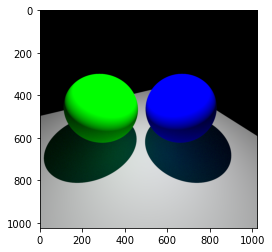

In [10]:
plt.imshow(gamma(reinhard(output)))
plt.show()